<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/growliflower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# カリフラワーインスタンスセグメンテーションモデルの作成

## ライセンス
- GrowliFlowerデータセット
    - http://rs.ipb.uni-bonn.de/data/growliflower/
    - https://phenoroam.phenorob.de/geonetwork/srv/eng/catalog.search#/metadata/cb328232-31f5-4b84-a929-8e1ee551d66a
- Kierdorf, J., Junker-Frohn, L. V., Delaney, M., Olave, M. D., Burkart, A., Jaenicke, H., Muller, O., Rascher, U., & Roscher, R. (2022). GrowliFlower: An image time‐series dataset for GROWth analysis of cauLIFLOWER. Journal of Field Robotics. https://doi.org/10.1002/rob.22122
    - CC-BY 4.0
- detectron2
    - https://github.com/facebookresearch/detectron2/tree/main
    - Apache-2.0
- 本ノートブック
    - CC-BY-NC 4.0

## 解説
GrowliFlowerは、カリフラワー畑からUAVを用いて画像撮影した時系列データセットです。この提案されたデータセットには、約14,000株の個々のカリフラワーのRGB画像と植物の位置を個体単位でマーキングしたアノテーションと、マルチスペクトルのオルソフォト（正射投影写真）が含まれています。今回はRGB画像とアノテーション情報を利用して、カリフラワーの領域分割を個体レベルで行うインスタンスセグメンテーションモデルを作成しましょう。

インスタンスセグメンテーションモデルを訓練するため、今回はfacebookresearch（現metaresearch）が公開しているdetectron2ライブラリを使用します。
## 備考
detectron2の設定ファイルは、YAML/YACS形式の記述に加え、LazyConfigsを用いたPython辞書型での管理方法もあります。設定項目の柔軟性を鑑み、2023年12月現在では後者の使用が推奨されています。しかし、このノートブックでは公式サンプルに追従し、前者の方法を採用します。

参考リンク：

https://detectron2.readthedocs.io/en/latest/tutorials/configs.html
https://detectron2.readthedocs.io/en/latest/tutorials/lazyconfigs.html

## 環境構築

In [2]:
#https://phenoroam.phenorob.de/geonetwork/srv/eng/catalog.search#/metadata/cb328232-31f5-4b84-a929-8e1ee551d66a
!wget https://phenoroam.phenorob.de/geonetwork/srv/api/records/cb328232-31f5-4b84-a929-8e1ee551d66a/attachments/79798936-GrowliFlowerL.zip
!unzip -q /content/79798936-GrowliFlowerL.zip

--2024-01-14 10:42:55--  https://phenoroam.phenorob.de/geonetwork/srv/api/records/cb328232-31f5-4b84-a929-8e1ee551d66a/attachments/79798936-GrowliFlowerL.zip
Resolving phenoroam.phenorob.de (phenoroam.phenorob.de)... 131.220.186.32
Connecting to phenoroam.phenorob.de (phenoroam.phenorob.de)|131.220.186.32|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 79798936 (76M) [application/zip]
Saving to: ‘79798936-GrowliFlowerL.zip’

79798936-GrowliFlow 100%[===================>]  76.10M  11.7MB/s    in 7.0s    

2024-01-14 10:43:03 (10.9 MB/s) - ‘79798936-GrowliFlowerL.zip’ saved [79798936/79798936]



In [3]:
# installation procedure from official repo.
# https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5
!python -m pip install pyyaml>5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install -q {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 15303, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 15303 (delta 9), reused 12 (delta 1), pack-reused 15275
Receiving objects: 100% (15303/15303), 6.18 MiB | 16.07 MiB/s, done.
Resolving deltas: 100% (11120/11120), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import cv2
import random
import pickle
import numpy as np
from multiprocessing import Pool
from google.colab.patches import cv2_imshow



import torch

import detectron2
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.evaluation.evaluator import DatasetEvaluators
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode


In [4]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


## detectron2に適合するデータセットを用意し、アノテーションを登録する

Detectron2 requires datasets in a specific format. You need to convert your dataset into a list of dictionaries, with each dictionary representing an image and its associated annotations. A typical entry may look like this:

```python
{
    "file_name": "path/to/image.jpg",
    "height": 1024,
    "width": 768,
    "image_id": 12345,
    "annotations": [
        {
            "bbox": [x, y, width, height],
            "bbox_mode": BoxMode.XYWH_ABS,
            "segmentation": [[x1, y1, x2, y2, ...]],
            "category_id": 0,
        },
        ...
    ]
}

# register
from detectron2.data import DatasetCatalog, MetadataCatalog

def get_my_dataset_dicts():
    # Your data loading logic here
    pass

for d in ["train", "val"]:
    DatasetCatalog.register("my_dataset_" + d, lambda d=d: get_my_dataset_dicts(d))
    MetadataCatalog.get("my_dataset_" + d).set(thing_classes=["class1", "class2", ...])
```

データセット登録をします。

In [5]:
def bgrmask2label(image, background_color = [168, 38, 62]):
    unique_colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)
    background_mask = np.all(image == background_color, axis=-1)
    lbl_image = np.zeros(image.shape[:2], dtype=np.uint8)
    lbl_image[~background_mask] = 255
    unique_colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)
    unique_colors = unique_colors[~np.all(unique_colors == background_color, axis=1)]
    for i, color in enumerate(unique_colors, start=1):
        color_mask = np.all(image == color, axis=-1)
        lbl_image[color_mask] = i
    return lbl_image


In [6]:
def process_image(file, img_dir, mask_dir):
    image_path = os.path.join(img_dir, file)
    basename = os.path.splitext(file)[0]
    mask_path = os.path.join(mask_dir, basename + "_Label_maskPlants.png")

    if not os.path.isfile(mask_path):
        return None

    mask = cv2.imread(mask_path)
    mask = bgrmask2label(mask)

    record = {"file_name": image_path, "image_id": image_path, "height": mask.shape[0], "width": mask.shape[1]}
    objs = []
    instances = np.unique(mask)
    for instance in instances:
        if instance == 0:
            continue
        binary_mask = np.uint8(mask == instance)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        polygons = []
        for contour in contours:
            epsilon = 0.005 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            poly = approx.flatten().tolist()
            if len(poly) <=4:
                # if less than 2 coords
                continue
            polygons.append(contour.flatten().tolist())
        if len(polygons) ==0:
            continue

        min_x, max_x = float('inf'), float('-inf')
        min_y, max_y = float('inf'), float('-inf')

        for polygon in polygons:
            for i in range(0, len(polygon), 2):
                x, y = polygon[i], polygon[i + 1]
                min_x, max_x = min(min_x, x), max(max_x, x)
                min_y, max_y = min(min_y, y), max(max_y, y)

        obj = {
            "bbox": [min_x, min_y, max_x, max_y],
            "bbox_mode": BoxMode.XYXY_ABS,
            "segmentation": polygons,
            "category_id": 0
        }
        objs.append(obj)
    record["annotations"] = objs
    return record

In [7]:
def get_GrowliFlowerDataset_multiprocess(img_dir, mask_dir):
    files = sorted(os.listdir(img_dir))

    # Create a pool of processes
    with Pool() as pool:
        # Map the process_image function to each file
        results = pool.starmap(process_image, [(file, img_dir, mask_dir) for file in files])

    # Filter out None results and return
    return [result for result in results if result is not None]

dataset_dictlist = get_GrowliFlowerDataset_multiprocess(img_dir = "/content/GrowliFlowerL/images/Train",
                                 mask_dir = "/content/GrowliFlowerL/labels/Train/maskPlants")
with open('growliflower_train.pkl', 'wb') as f:
    pickle.dump(dataset_dictlist, f)

dataset_dictlist = get_GrowliFlowerDataset_multiprocess(img_dir = "/content/GrowliFlowerL/images/Val",
                                 mask_dir = "/content/GrowliFlowerL/labels/Val/maskPlants")
with open('growliflower_val.pkl', 'wb') as f:
    pickle.dump(dataset_dictlist, f)

dataset_dictlist = get_GrowliFlowerDataset_multiprocess(img_dir = "/content/GrowliFlowerL/images/Test",
                                 mask_dir = "/content/GrowliFlowerL/labels/Test/maskPlants")
with open('growliflower_test.pkl', 'wb') as f:
    pickle.dump(dataset_dictlist, f)

In [8]:
def load_GrowliFlower_pickle(subset):
    with open(f'growliflower_{subset}.pkl', 'rb') as f:
        return pickle.load(f)

for d in ["train", "val", "test"]:
    DatasetCatalog.register("GrowliFlower_" + d, lambda d=d: load_GrowliFlower_pickle(d))
    MetadataCatalog.get("GrowliFlower_" + d).set(thing_classes=["cauliflower"])
metadata = MetadataCatalog.get("GrowliFlower_train")

/content/GrowliFlowerL/images/Train/patch_2020_08_12_38732.jpg


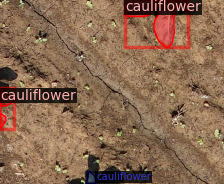

/content/GrowliFlowerL/images/Train/patch_2020_08_19_14718.jpg


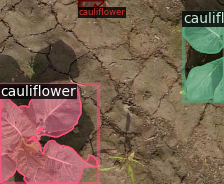

/content/GrowliFlowerL/images/Train/patch_2020_08_12_101625.jpg


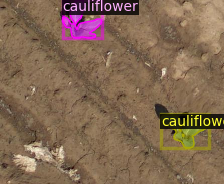

In [9]:
dataset = load_GrowliFlower_pickle("train")

for d in random.sample(dataset, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## configuration

In [14]:
#model zoo
#https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("GrowliFlower_train",)
cfg.DATASETS.TEST = ("GrowliFlower_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

In [ ]:
# validation training issue
# https://github.com/facebookresearch/detectron2/issues/4368

class TrainerWithVal(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder="/content/output/val"):
        coco_evaluator = COCOEvaluator(dataset_name, output_dir=output_folder)
        evaluator_list = [coco_evaluator]
        return DatasetEvaluators(evaluator_list)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(cfg.OUTPUT_DIR, "val"), exist_ok=True)

cfg.TEST.EVAL_PERIOD =  200
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.50
trainer = TrainerWithVal(cfg)
#trainer.build_evaluator()

trainer.resume_or_load(resume=False)
trainer.train()
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

[01/14 11:42:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


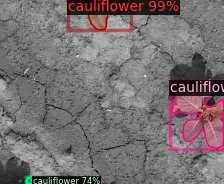

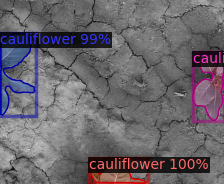

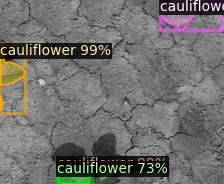

In [19]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = load_GrowliFlower_pickle("test")

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])